<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Exoplanet Transit Guide</title>
    <style>
        h1, h2 {
            color: skyblue;
        }
    </style>
</head>
<body>

<h1>Exoplanet Transit Guide</h1>

<h2>Section 0: Overview</h2>
<p>
I have broken down the process of capturing and processing an exoplanet transit into eight steps which are outlined below. This quick overview will help the reader understand the whole process before diving into the specific details of each step. If you are just working with the provided transit images then you can skip step 1.
</p>
<ul>
    <li><a href="#selecting-a-transit">Section 1: Selecting a Transit</a> - This section describes 6 things to keep in mind when selecting a transit. It also provides some good resources for finding a suitable transit.</li>
    <li><a href="#Loading-Images">Section 2: Loading Images</a></li>
    <li><a href="#Flat/Bias-Correction">Section 3: Image Noise Correction</a></li>
    <li><a href="#Aperture-Test">Section 4: Aperture Test</a></li>
    <li><a href="#Star-Tracking">Section 5: Star Tracking</a></li>
    <li><a href="#Differential-Photometry">Section 6: Differential Photometry</a></li>
    <li><a href="#Plotting-Transit">Section 7: Plotting Transit</a></li>
    <li><a href="#Estimating-Exoplanet-Information">Section 8: Estimating Exoplanet Information</a></li>
</ul>


<h2 style="color: skyblue;" id="selecting-a-transit">Section 1: Selecting a Transit</h2>
<p>
When selecting the exoplanet transit the weather is of course important above all else. Clouds can cause a drop in brightness over 40% in my experience and when looking for a drop around 1% this can make it impossible to measure even with differential photometry. If you're using the York University observatory they provide a great resource for helping you choose a clear night for your transit but the data is only for the next 72 hours: <a href="https://www.cleardarksky.com/c/YrkUObONkey.html?1">York University Observatory Clear Sky Chart</a>. Once you have a clear night selected there are 5 main things to think about for selecting the specific transit:
</p>
<ol>
    <li><strong>Stellar Magnitude</strong> - The brightness measurement. With the light collecting power of the 1 meter telescope the upper limit is around 15. Any less bright and the exposure times would likely be too long. If you find a transit around 14-15 Vmag you can look at the starfield by generating a starfield with the <a href="http://var2.astro.cz/ETD/predictions.php">Exoplanet Transit Database</a> to ensure there are no other really bright stars in the FOV. If this is the case you may be able to capture the transit with long exposure times.</li>
    <li><strong>Transit Depth</strong> - Generally we want a drop in brightness around 1% or more in order to accurately extract the transit but a larger transit depth is always easier to detect.</li>
    <li><strong>Transit Duration</strong> - The length of the transit is important because of telescope availability as well as finding a window of good weather. The shorter the transit the higher the chances of success.</li>
    <li><strong>Transit Start Time</strong> - You need the transit to occur at night and ideally you want it to start at least 1 hour and 15 minutes after sunset (45 mins for twilight and 30 mins for a baseline before the transit). The <a href="https://www.cleardarksky.com/c/YrkUObONkey.html?1">York University Observatory Clear Sky Chart</a> has estimates for the brightness.</li>
    <li><strong>Celestial Position</strong> - The following link can be used to ensure that your object is at least 20 degrees above the horizon from 30 minutes before to 30 minutes after the transit: <a href="http://catserver.ing.iac.es/staralt/index.php">STARALT</a></li>
</ol>
<p>
The <a href="http://var2.astro.cz/ETD/predictions.php">Exoplanet Transit Database</a> is a great resource. With a given Lat and Long and date it will give you a list of confirmed transits that are visible from your location and more than 20 degrees above the horizon mid transit. It can also be used to make a finder chart so that you can identify which star is the transit star. It also includes all of the important information mentioned above. You can then input the given RA and Dec into <a href="http://catserver.ing.iac.es/staralt/index.php">STARALT</a></li> to confirm it is viewable for the entire transit.
</p>


<h2 style="color: skyblue;" id="Loading-Images">Section 2: Loading Images</h2>
<p>

 After you download the images, you will be given the following: 
 <li> 20 bias frames, ex. "Bias_2x2-0001" </li>
 <li>20 flat frames, ex. "Flat_R_2x2_0001" </li>
 You will also be given the transit images, ex. "KOI-13_LIGHT_R_3s_BIN2_-10C_001_20240519_222732_343_PA36.04" 

Ensure that both your transit images and your Flat images you download contain the same filter, which should be red. This is indicated by the _ R _ in the names. The name of the transit images include the date and time the image was taken.
</p>

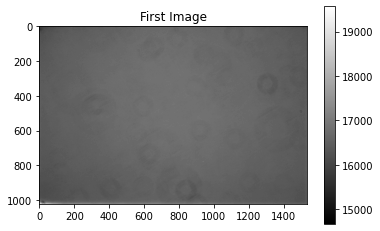

In [1]:
import os
from astropy.io import fits
import matplotlib.pyplot as plt

def load_fits_images(folder_path, keyword):
    """
    Loads all fits images from a given folder that have the given keyword and stores the time the image was taken as well.
    ex: Flat_R to load flats images with the red filter
    """
    images = []
    
    for filename in os.listdir(folder_path):
        if keyword in filename:
            file_path = os.path.join(folder_path, filename)
            with fits.open(file_path) as hdul:
                image_data = hdul[0].data
                images.append({'data': image_data, 'filename': filename, 'header': hdul[0].header})

    if not images:
        raise FileNotFoundError(f"No FITS files with keyword '{keyword}' found in the folder '{folder_path}'")

    return images

# Example usage
folder = "D:\\TransitResearch\\2024-05-31\\HAT-P-27b"
keyword = "FLAT_R"
images = load_fits_images(folder, keyword)

# show the first image
plt.figure()
plt.imshow(images[0]['data'], cmap='gray')
plt.title('First Image')
plt.colorbar()
plt.show()

# clear memory of unneeded images
del images



<h2 style="color: skyblue;" id="Flat/Bias-Correction">Section 3: Image Noise Correction</h2>
<p>

## Bias Frames
These are images taken with the smallest exposure time possible (0.1s at the Yorku observatory) and the shutter closed so there is no light. They are used to correct for electric noise introduced during the readout process. They usually take about 20 of these when observing with the 1 meter because of the diminishing returns, but for exoplanet transits you need very accurate noise removal so the more you have the better your noise correction. If there was observing done the day before or after you at the observatory, don't hesitate to ask for access so that you can use the flats and bais images taken those days as well provided they are taken at the same ccd temperature setting and 2X2 binning, or even take more bias images before or after capturing your transit.

## Flat Frames ## 
These are images taken of a uniformly lit surface. At the Yorku observatory they are taken with a lamp pointed at the telescope dome. They are used to correct for the slightly different sensitivity of each pixel in the CCD camera. They also correct for any artifacts or dust in the optical path. Same deal for these as bias frames; although diminishing returns, the more you have the better your noise correction.

## Calibrating frames
<ol>
<li> Load the bias frames and flat frames.</li>
<li> Load your science(Transit) frames. First, we need to align the stars in each of the frames. astropy has a tool called astroalign that can be used to do this. </li>
<li> Inspect your set of bias and flat images to ensure there are no outliers or bad frames. To do this, check the mean, median, and standard deviation of the frames and compare them. This makes sure that none of your bias frames are introducing more noise to the image.</li>
<li> Combine your bias frames into a single frame using something like median combination. </li>
<li> Next we need to clean the flat frames. Apply cosmic ray removal. Libraries like astropy have tools for this, but the best library that I know for this in python is Astroscrappy. </li>
<li> Subtract your bias frame from each flat frame, or use a library like astropy ccdproc for the correction. You can then normalize each flat frame. </li>
<li> Combine these flat frames using something like median combination to create a single flat frame. </li>
<li> Correct for the bias in each of your science frames by either subtracting, or using something like an astropy ccdproc tool. Then correct for the flats in each of your science frames by either dividing by the combined frame, or using astropy ccdproc or another tool alike.</li>
<li> Now that you have corrected for flats and bias; you need to perform cosmic ray correction first, ,then background subtraction for each of your science frames. Astropy photoutils has lots of different tools for dynamic/adaptive background subtraction and the Astroscrappy library I mentioned before can be used again for cosmic ray correction</li>
</ol>
</p>


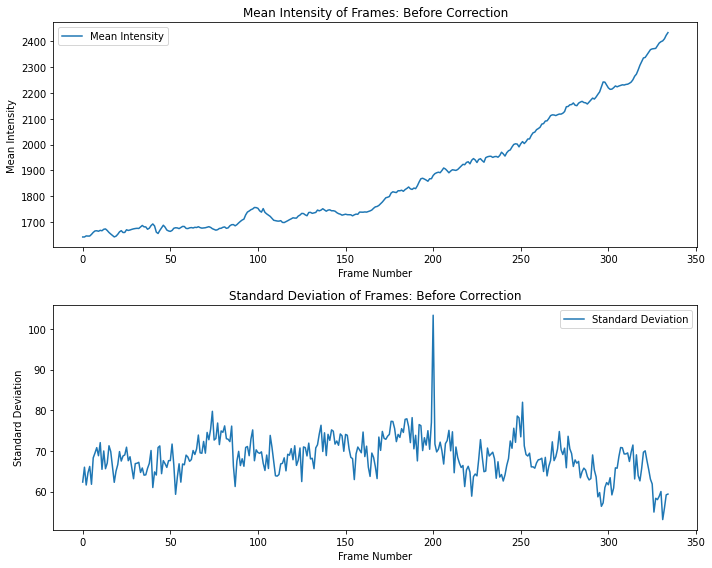

Removed 2 outlier frames before correction: ['D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_201_20240601_014224_598_PA115.85.FIT', 'D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_332_20240601_024311_770_PA115.79.FIT']
Successfully processed and saved: D:\TransitResearch\2024-05-31\calibrated_images3\HAT-P-27_LIGHT_R_19s_BIN2_-10C_001_20240601_000821_376_PA116.06.FIT
Successfully processed and saved: D:\TransitResearch\2024-05-31\calibrated_images3\HAT-P-27_LIGHT_R_19s_BIN2_-10C_002_20240601_000849_378_PA116.06.FIT
Successfully processed and saved: D:\TransitResearch\2024-05-31\calibrated_images3\HAT-P-27_LIGHT_R_19s_BIN2_-10C_003_20240601_000916_828_PA116.06.FIT
Successfully processed and saved: D:\TransitResearch\2024-05-31\calibrated_images3\HAT-P-27_LIGHT_R_19s_BIN2_-10C_004_20240601_000944_284_PA116.06.FIT
Successfully processed and saved: D:\TransitResearch\2024-05-31\calibrated_images3\HAT-P-27_LIGHT_R_19s_BIN2_-10C_005_202

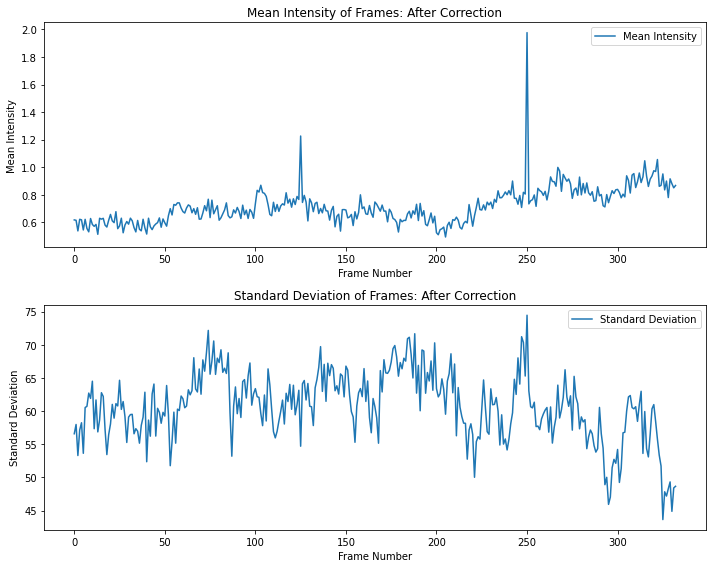

Removed 4 outlier frames after correction: ['D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_126_20240601_010618_019_PA115.91.FIT', 'D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_251_20240601_020535_568_PA115.82.FIT', 'D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_326_20240601_024025_279_PA115.79.FIT', 'D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_331_20240601_024243_916_PA115.79.FIT']
Files removed before correction: ['D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_201_20240601_014224_598_PA115.85.FIT', 'D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_332_20240601_024311_770_PA115.79.FIT']
Files removed after correction: ['D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_126_20240601_010618_019_PA115.91.FIT', 'D:\\TransitResearch\\2024-05-31\\HAT-P-27b\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_251_2024

In [11]:
import numpy as np
import os
from astropy.io import fits
from astropy.nddata import CCDData
import ccdproc
import astroalign as aa
from astroscrappy import detect_cosmics
from photutils.background import Background2D, SExtractorBackground
import matplotlib.pyplot as plt

def load_fits_images(folder, tag):
    """Load FITS files based on a tag from a specified folder and return both the HDUList and filenames."""
    files = [os.path.join(folder, f) for f in os.listdir(folder) if tag in f]
    return [(fits.open(file), file) for file in files]

def plot_statistics(data, title):
    """Plot mean and standard deviation of data."""
    means = [np.mean(frame.data) for frame in data]
    stds = [np.std(frame.data) for frame in data]
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(means, label='Mean Intensity')
    ax[0].set_title(f'Mean Intensity of Frames: {title}')
    ax[0].set_xlabel('Frame Number')
    ax[0].set_ylabel('Mean Intensity')
    ax[0].legend()
    ax[1].plot(stds, label='Standard Deviation')
    ax[1].set_title(f'Standard Deviation of Frames: {title}')
    ax[1].set_xlabel('Frame Number')
    ax[1].set_ylabel('Standard Deviation')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

def filter_outliers(frames, n_sigma=3):
    """Identify and filter out outlier frames based on mean and standard deviation."""
    means = np.array([np.mean(frame.data) for frame in frames])
    stds = np.array([np.std(frame.data) for frame in frames])
    mean_of_means = np.mean(means)
    std_of_means = np.std(means)
    mean_of_stds = np.mean(stds)
    std_of_stds = np.std(stds)
    
    good_frames = []
    removed_indices = []
    for i, (mean, std) in enumerate(zip(means, stds)):
        if (abs(mean - mean_of_means) > n_sigma * std_of_means) or (abs(std - mean_of_stds) > n_sigma * std_of_stds):
            removed_indices.append(i)
        else:
            good_frames.append(frames[i])
    return good_frames, removed_indices

def calibrate_and_save_images(science_images, flat_images, bias_images, output_folder):
    """Calibrate science images using provided flat and bias frames, perform cosmic ray removal, background subtraction, realign images and save the calibrated images."""
    bias_data = [CCDData(img[0].data, unit='adu') for img, _ in bias_images]
    combined_bias = ccdproc.combine(bias_data, method='median')

    flat_data = [CCDData(img[0].data, unit='adu') for img, _ in flat_images]
    corrected_flats = [ccdproc.subtract_bias(flat, combined_bias) for flat in flat_data]
    for flat in corrected_flats:
        cosmic_mask, clean_data = detect_cosmics(flat.data, gain=1.0, readnoise=10.0, sigclip=5.0)
        flat.data = clean_data
    normalized_flats = [flat.divide(np.median(flat.data[flat.data > 0])) for flat in corrected_flats]
    combined_flat = ccdproc.combine(normalized_flats, method='median')

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    science_ccds = [CCDData(img[0].data, unit='adu', meta=img[0].header.copy()) for img, _ in science_images]
    
    # Plot statistics before correction
    plot_statistics(science_ccds, "Before Correction")
    
    science_ccds, removed_indices_before = filter_outliers(science_ccds)
    removed_files_before = [science_images[i][1] for i in removed_indices_before]
    print(f"Removed {len(removed_indices_before)} outlier frames before correction: {removed_files_before}")

    corrected_science_ccds = []
    reference_image = None

    for i, science_ccd in enumerate(science_ccds):
        filename = science_images[i][1]  # Use original filename from input list
        try:
            if reference_image is None:
                reference_image = science_ccd

            aligned_data, _ = aa.register(science_ccd.data, reference_image.data)
            aligned_ccd = CCDData(aligned_data, unit='adu', meta=science_ccd.meta)
            corrected_ccd = ccdproc.subtract_bias(aligned_ccd, combined_bias)
            corrected_ccd = ccdproc.flat_correct(corrected_ccd, combined_flat)

            cosmic_mask, clean_data = detect_cosmics(corrected_ccd.data, gain=1.0, readnoise=10.0, sigclip=5.0, sigfrac=0.3)
            corrected_ccd.data = clean_data
            bkg_estimator = SExtractorBackground()
            bkg = Background2D(corrected_ccd.data, (100, 100), filter_size=(5, 5), bkg_estimator=bkg_estimator)
            corrected_ccd.data -= bkg.background

            if reference_image is not None:
                realigned_data, _ = aa.register(corrected_ccd.data, reference_image.data)
                corrected_ccd = CCDData(realigned_data, unit='adu', meta=science_ccd.meta)

            corrected_science_ccds.append(corrected_ccd)

            output_file = os.path.join(output_folder, os.path.basename(filename))
            fits.writeto(output_file, corrected_ccd.data, corrected_ccd.meta, overwrite=True)
            print(f"Successfully processed and saved: {output_file}")
        except Exception as e:
            print(f"Failed to process {os.path.basename(filename)}: {e}")

    # Plot statistics after correction
    plot_statistics(corrected_science_ccds, "After Correction")
    
    corrected_science_ccds, removed_indices_after = filter_outliers(corrected_science_ccds)
    removed_files_after = [science_images[i][1] for i in removed_indices_after]
    print(f"Removed {len(removed_indices_after)} outlier frames after correction: {removed_files_after}")

    return removed_files_before, removed_files_after

# Example usage
folder = "D:\\TransitResearch\\2024-05-31\\HAT-P-27b"
flat_images = load_fits_images(folder, "FLAT_R")
bias_images = load_fits_images(folder, "Bias")
science_images = load_fits_images(folder, "HAT-P-27")
output_folder = "D:\\TransitResearch\\2024-05-31\\calibrated_images3"

removed_files_before, removed_files_after = calibrate_and_save_images(science_images, flat_images, bias_images, output_folder)
print(f"Files removed before correction: {removed_files_before}")
print(f"Files removed after correction: {removed_files_after}")







<h2 style="color: skyblue;" id="Aperture-Test">Section 4: Aperture Test</h2>
<p>
The aperture test is for choosing an acceptable aperture for your transit and reference stars. It involves increasing the aperture that you measure around the star so that it matches the stars size and doesn't include any extra background flux than needed, but still includes the entire star. The steps for aperture photometry are outlined below:
 
Star detection- Either manually choose the pixels of the center of your transit and reference stars, or using a star detection library such as Photoutils.detection.DAOStarFinder, or photoutils.detection.find_peaks. If you are not manually choosing the stars then you can add certian checks to ensure you choose acceptable comp stars; 

ex:
<li>check if the Gaussian FWHM is at least 2 pixels. This is a measure of the PSF. </li>
<li>ensure the star is not too close to the edge; some stars will not be in frame for all images.</li>
<li>choose the stars that are closest in brightness to your transit star.</li>

once you have a list of stars you can run an aperture test for each. The aperture test involves increasing the aperture, and taking the sum of all the pixels each time. You then plot the sum for each aperture. If your images is focused properly and you have chosen an acceptable comp star, your curve should look something like the image below. As you can see from the plot, an aperture around 7 would capture the whole transit star in this case.

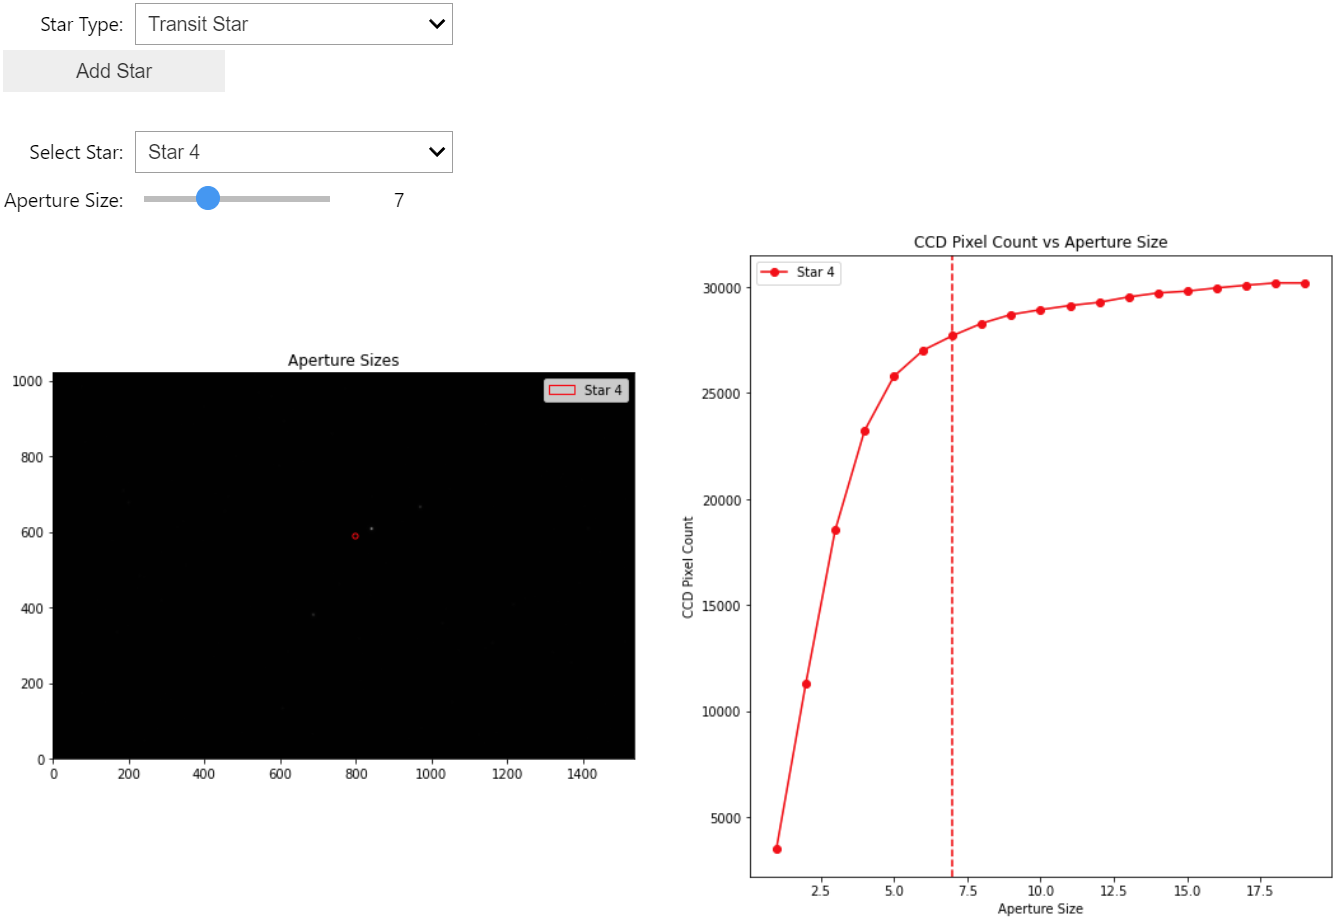

you can also identify which stars are your comparison, and which is your transit star. first get a finder chart from <a href="http://var2.astro.cz/ETD/predictions.php">Exoplanet Transit Database</a> to help you find which star is yours. its not necessarily the brightest or in the exact center of your image, so you need this to identify your star. 

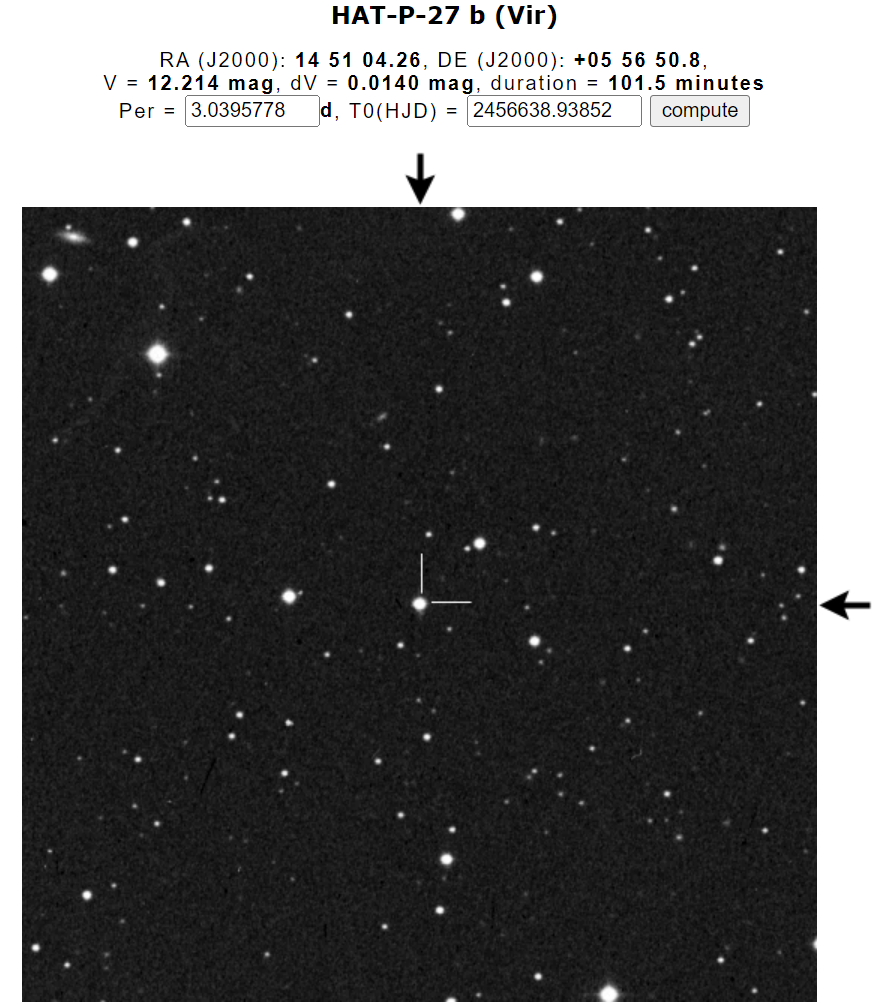
</p>

interactive(children=(Dropdown(description='Select Star:', options=(('Star 1', 1), ('Star 2', 2), ('Star 3', 3…

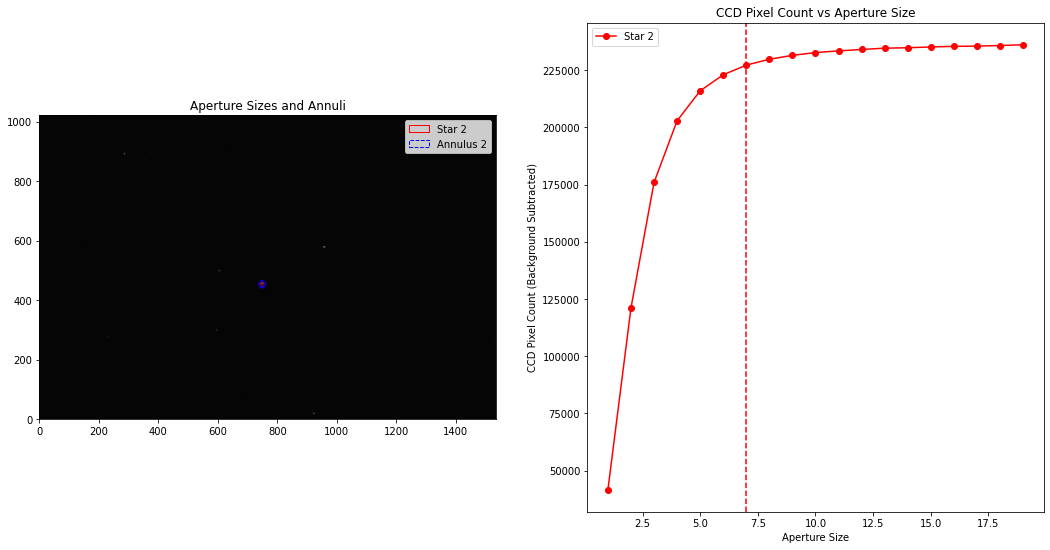

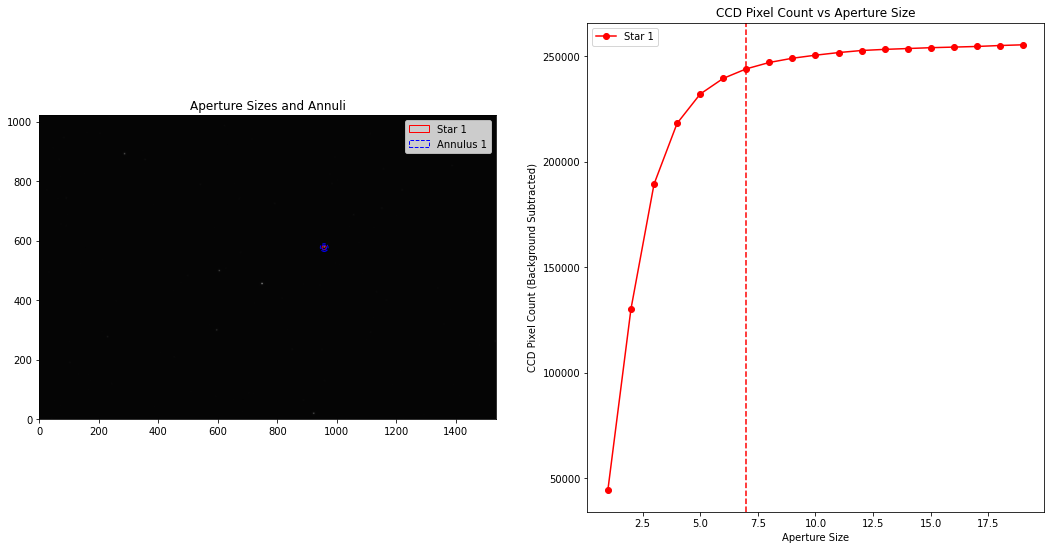

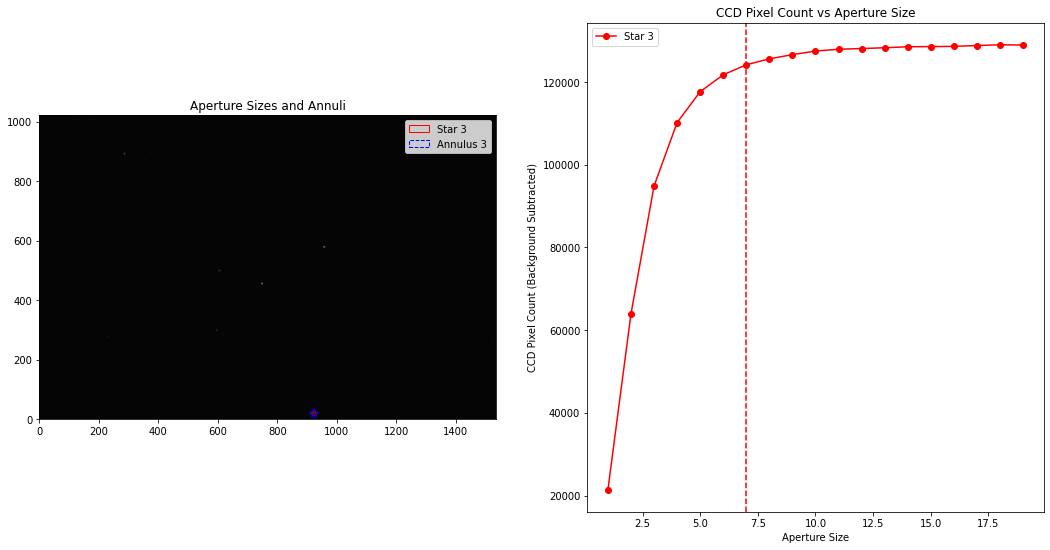

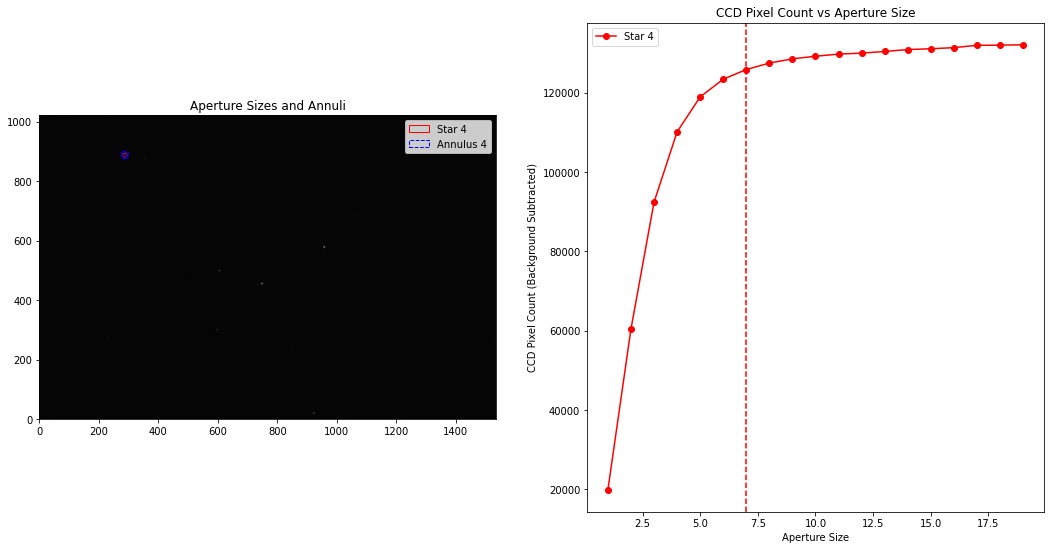

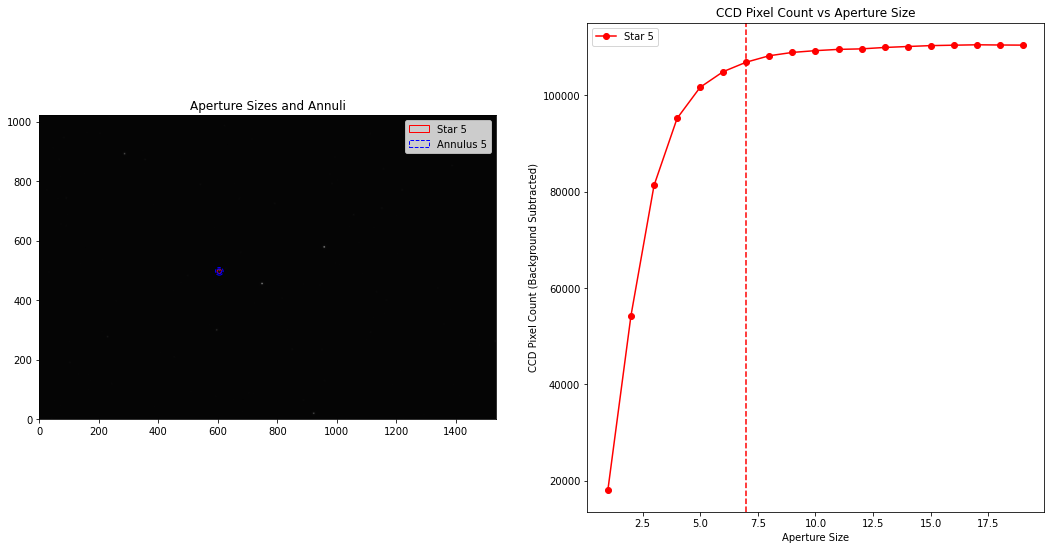

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from ipywidgets import IntSlider, Dropdown, Button, VBox, Output, interactive
from astropy.stats import sigma_clipped_stats
from photutils.background import Background2D, MedianBackground
from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter

class ApertureTest:
    def __init__(self):
        self.selected_stars = []
        self.out = Output()

    def perform_test(self, filepath, aperture_sizes, annulus_radii):
        try:
            with fits.open(filepath) as hdul:
                frame_data = hdul[0].data
        except Exception as e:
            print(f"Error opening FITS file: {e}")
            return

        bkg = Background2D(frame_data, (50, 50), filter_size=(3, 3), bkg_estimator=MedianBackground())
        data_sub = frame_data - bkg.background
        mean, median, std = sigma_clipped_stats(data_sub, sigma=3.0)
        threshold = 20.0 * std
        tbl = find_peaks(data_sub, threshold, box_size=11)

        if tbl is not None and len(tbl) > 0:
            sorted_sources = tbl[np.argsort(tbl['peak_value'])[::-1]][:40]
            positions = np.array(list(zip(sorted_sources['x_peak'], sorted_sources['y_peak'])))
            brightness = sorted_sources['peak_value']

            valid_positions = []
            valid_brightness = []

            for i, pos in enumerate(positions):
                x, y = pos
                size = 5
                if x-size < 0 or x+size >= data_sub.shape[1] or y-size < 0 or y+size >= data_sub.shape[0]:
                    continue

                cutout = data_sub[y-size:y+size+1, x-size:x+size+1]
                y_grid, x_grid = np.mgrid[:cutout.shape[0], :cutout.shape[1]]
                initial_guess = Gaussian2D(amplitude=cutout.max(), x_mean=size, y_mean=size)
                fit_p = LevMarLSQFitter()

                try:
                    gauss_fit = fit_p(initial_guess, x_grid, y_grid, cutout)
                    fwhm_x = 2.355 * gauss_fit.x_stddev.value
                    fwhm_y = 2.355 * gauss_fit.y_stddev.value
                    fwhm = np.sqrt(fwhm_x * fwhm_y)

                    if fwhm >= 2:
                        valid_positions.append(pos)
                        valid_brightness.append(brightness[i])
                except Exception as e:
                    print(f"Gaussian fit failed for star at position {pos}: {e}")

            if len(valid_positions) == 0:
                print("No valid stars found with FWHM >= 3 pixels.")
                return

            self.positions = np.array(valid_positions)
            self.brightness = np.array(valid_brightness)
            self.aperture_sums = []
            self.annulus_medians = []
            self.frame_data = frame_data
            self.aperture_sizes = aperture_sizes
            self.annulus_radii = annulus_radii
            
            for aperture_size in aperture_sizes:
                aperture = CircularAperture(self.positions, r=aperture_size)
                phot_table = aperture_photometry(data_sub, aperture)
                aperture_sum_values = np.maximum(phot_table['aperture_sum'], 0)
                self.aperture_sums.append(aperture_sum_values)

                # Determine annulus for background subtraction
                annulus_aperture = CircularAnnulus(self.positions, r_in=aperture_size+annulus_radii[0], r_out=aperture_size+annulus_radii[1])
                annulus_masks = annulus_aperture.to_mask(method='center')
                local_background = []

                for mask in annulus_masks:
                    annulus_data = mask.multiply(data_sub)
                    mask_data = annulus_data[mask.data > 0]
                    mean_sigclip, median_sigclip, std_sigclip = sigma_clipped_stats(mask_data)
                    local_background.append(median_sigclip)

                self.annulus_medians.append(np.array(local_background))

            self.create_widgets()

    def create_widgets(self):
        star_selector = Dropdown(options=[(f'Star {i+1}', i+1) for i in range(len(self.positions))], description='Select Star:')
        star_type_selector = Dropdown(options=[('Transit Star', 'Transit Star'), ('Comparison Star', 'Comparison Star')], description='Star Type:')
        slider = IntSlider(min=self.aperture_sizes.min(), max=self.aperture_sizes.max(), step=1, value=self.aperture_sizes[len(self.aperture_sizes) // 2], description='Aperture Size:')
        add_button = Button(description='Add Star')

        def plot_pixel_count_and_image(selected_star, aperture_size):
            selected_star_idx = selected_star - 1
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
            ax1.imshow(self.frame_data, cmap='gray', origin='lower')
            color = 'red'
            pos = self.positions[selected_star_idx]
            aperture = CircularAperture([pos], r=aperture_size)
            annulus_aperture = CircularAnnulus([pos], r_in=aperture_size+self.annulus_radii[0], r_out=aperture_size+self.annulus_radii[1])
            aperture.plot(ax1, color=color, label=f'Star {selected_star}')
            annulus_aperture.plot(ax1, color='blue', linestyle='dashed', label=f'Annulus {selected_star}')
            ax1.legend()
            ax1.set_title('Aperture Sizes and Annuli')
            ax2.plot(self.aperture_sizes, [ap_sum[selected_star_idx] - annulus_median[selected_star_idx] for ap_sum, annulus_median in zip(self.aperture_sums, self.annulus_medians)], marker='o', color=color, label=f'Star {selected_star}')
            ax2.axvline(x=aperture_size, color=color, linestyle='--')
            ax2.set_xlabel('Aperture Size')
            ax2.set_ylabel('CCD Pixel Count (Background Subtracted)')
            ax2.set_title('CCD Pixel Count vs Aperture Size')
            ax2.legend()
            plt.show()

        def add_star_to_list(selected_star, aperture_size, star_type):
            selected_star_idx = selected_star - 1
            pos = self.positions[selected_star_idx]
            annulus_size = (aperture_size + self.annulus_radii[0], aperture_size + self.annulus_radii[1])
            self.selected_stars.append({'star': selected_star, 'position': pos, 'aperture_size': aperture_size, 'annulus_size': annulus_size, 'type': star_type})
            with self.out:
                print(f"Added {star_type} Star {selected_star} at position {pos} with aperture size {aperture_size} and annulus size {annulus_size}")
            plot_pixel_count_and_image(selected_star, aperture_size)

        def on_button_click(b):
            add_star_to_list(star_selector.value, slider.value, star_type_selector.value)

        add_button.on_click(on_button_click)

        display(VBox([star_type_selector, add_button, self.out]))
        
        interactive_plot = interactive(plot_pixel_count_and_image, selected_star=star_selector, aperture_size=slider)
        display(interactive_plot)

    def get_selected_stars(self):
        return self.selected_stars

# Perform the test on a single image file
aperture_test = ApertureTest()
aperture_sizes = np.arange(1, 20, 1)
annulus_radii = (1, 6)
aperture_test.perform_test("D:\\TransitResearch\\2024-05-31\\calibrated_images3\\HAT-P-27_LIGHT_R_19s_BIN2_-10C_021_20240601_001737_918_PA116.04.fit", aperture_sizes, annulus_radii)
#aperture_test.perform_test("D:\\TransitResearch\\EXOTIC_sampledata-1.0.0\\EXOTIC_sampledata-1.0.0\\HatP32Dec202017\\HATP-32171220013343.fits", aperture_sizes)

# To access the selected stars list:
selected_stars = aperture_test.get_selected_stars()

# Example of accessing the pixel coordinates, aperture size, annulus size, and star type
for star in selected_stars:
    print(f"Star: {star['star']}, Position: {star['position']}, Aperture Size: {star['aperture_size']}, Annulus Size: {star['annulus_size']}, Type: {star['type']}")


<h2 style="color: skyblue;" id="Differential-Photometry">Section 6: Differential Photometry</h2>
<p>
</p>

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from datetime import datetime
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.stats import sigma_clip
from scipy.signal import savgol_filter
import george
from george import kernels
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Perform aperture photometry
def perform_aperture_photometry(image_data, positions, aperture_radius=5):
    """Perform aperture photometry on given positions in the image data."""
    apertures = CircularAperture(positions, r=aperture_radius)
    phot_table = aperture_photometry(image_data, apertures)
    fluxes = phot_table['aperture_sum']
    return fluxes

# Plot stars on the image
def plot_stars(image_data, recentered_positions, aperture_radius=5):
    """Plot target and comparison stars on the image."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image_data, cmap='gray', origin='lower', vmin=np.percentile(image_data, 5), vmax=np.percentile(image_data, 95))
    apertures = CircularAperture(recentered_positions, r=aperture_radius)
    apertures.plot(color='red', lw=1.5, alpha=0.7)
    
    for i, pos in enumerate(recentered_positions):
        label = 'Target' if i == 0 else f'Comp {i}'
        plt.text(pos[0], pos[1], label, color='yellow', fontsize=12)
    
    plt.title('Transit and Comparison Stars')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.grid(True)
    plt.show()

# Plot brightness curves
def plot_brightness_curves(times, target_fluxes, comparison_fluxes):
    """Plot the brightness curves of the target and comparison stars."""
    plt.figure(figsize=(10, 6))
    plt.plot(times, target_fluxes, marker='o', linestyle='-', color='b', label='Target Star')
    
    for j, comp_flux in enumerate(comparison_fluxes):
        plt.plot(times, comp_flux, marker='o', linestyle='-', label=f'Comparison Star {j+1}')
    
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.title('Brightness Curves')
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Calculate weighted average of comparison star fluxes
def weighted_average_comparison_fluxes(comparison_fluxes):
    """Calculate the weighted average of comparison star fluxes."""
    weights = [1 / np.var(flux) for flux in comparison_fluxes]
    weighted_fluxes = np.average(comparison_fluxes, axis=0, weights=weights)
    return weighted_fluxes

# Perform Gaussian Process Regression for noise removal
def apply_gaussian_process(times, flux):
    """Apply Gaussian Process Regression to remove noise from flux data."""
    times = np.array(times)
    kernel = kernels.Matern32Kernel(np.var(flux))
    gp = george.GP(kernel)
    gp.compute(times)
    mu, _ = gp.predict(flux, times, return_var=True)
    return mu

# Differential photometry
def differential_photometry(folder_path, keyword, recentered_positions, aperture_radius=5):
    """Perform differential photometry to detect exoplanet transits."""
    times = []
    target_fluxes = []
    comparison_fluxes = [[] for _ in range(len(recentered_positions[0]) - 1)]
    
    for i, filename in enumerate(sorted(os.listdir(folder_path))):
        if keyword in filename:
            file_path = os.path.join(folder_path, filename)
            try:
                with fits.open(file_path) as hdul:
                    image_data = hdul[0].data
                    header = hdul[0].header
                    time = datetime.strptime(header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S.%f')
                    times.append(time)

                    if i == 0:
                        plot_stars(image_data, recentered_positions[i], aperture_radius)

                    target_flux = perform_aperture_photometry(image_data, [recentered_positions[i][0]], aperture_radius=aperture_radius)[0]
                    target_fluxes.append(target_flux)

                    for j in range(len(comparison_fluxes)):
                        comp_flux = perform_aperture_photometry(image_data, [recentered_positions[i][j+1]], aperture_radius=aperture_radius)[0]
                        comparison_fluxes[j].append(comp_flux)
            except Exception as e:
                logging.error(f"Error processing file {file_path}: {e}")
    
    # Sigma clipping to remove outliers
    target_fluxes = sigma_clip(target_fluxes, sigma=3, maxiters=2)
    for j in range(len(comparison_fluxes)):
        comparison_fluxes[j] = sigma_clip(comparison_fluxes[j], sigma=3, maxiters=2)
    
    plot_brightness_curves(times, target_fluxes, comparison_fluxes)
    
    times_num = np.array([datetime.timestamp(t) for t in times])
    
    weighted_comparison_flux = weighted_average_comparison_fluxes([flux.data for flux in comparison_fluxes])
    normalized_flux = np.array(target_fluxes.data) / weighted_comparison_flux

    median_filtered_flux = savgol_filter(normalized_flux, window_length=11, polyorder=2)
    clipped_flux = sigma_clip(median_filtered_flux, sigma=3, maxiters=2)
    
    cleaned_flux = apply_gaussian_process(times_num, clipped_flux)

    plt.figure(figsize=(10, 6))
    plt.plot(times, normalized_flux, marker='o', linestyle='-', color='b', label='Normalized Flux')
    plt.plot(times, cleaned_flux, linestyle='-', color='r', label='GP Cleaned Flux')
    plt.xlabel('Time')
    plt.ylabel('Normalized Flux')
    plt.title('Differential Light Curve')
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Example usage
folder = "D:\\TransitResearch\\2024-05-31\\calibrated_images3"
keyword = "HAT"
# recentered_positions = recenter_stars(folder, keyword, initial_positions, box_size=aperture_size)

differential_photometry(folder, keyword, recentered_positions)





NameError: name 'positions' is not defined

<h2 style="color: skyblue;" id="plotting-transit-brightness">Section 7: Plotting Transit</h2>
<p>
</p>

<h2 style="color: skyblue;" id="estimating-exoplanet-information">Section 8: Estimating Exoplanet Information</h2>
<p>
</p>